# So sánh GA-APPA với APPA gốc

Notebook này so sánh thuật toán cải tiến GA-APPA (sử dụng Genetic Algorithm cho Phase 1) với thuật toán APPA gốc (sử dụng ETR heuristic).

## Các metrics so sánh:
- Max Completion Time (thời gian hoàn thành tối đa)
- Workload Balance (cân bằng tải)
- Efficiency Ratio (tỷ lệ hiệu quả)
- Execution Time (thời gian thực thi)
- Deviation Ratio (tỷ lệ cải thiện)

In [1]:
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
import time
import random
from typing import Dict, List

# Import algorithms
from algorithm.appa import APPAAlgorithm
from algorithm.ga_appa import GAPPAAlgorithm
from utils.create_sample import create_sample
from utils.config import UAV, Region, RANDOM_SEED
from utils.metrics import MetricsCalculator

# Set style
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 12

# Create output directory
os.makedirs('./fig', exist_ok=True)

print("Đã import thành công các thư viện!")

Đã import thành công các thư viện!


## 1. Tạo dữ liệu thử nghiệm

In [2]:
# Tạo dữ liệu thử nghiệm với các cấu hình khác nhau
def generate_test_data(num_uavs=4, num_regions=30, seed=RANDOM_SEED):
    """Tạo dữ liệu thử nghiệm"""
    random.seed(seed)
    np.random.seed(seed)
    
    data = create_sample(
        NUM_UAVS=num_uavs, 
        NUM_REGIONS=num_regions,
        SYSTEM_AREA_RATIO=0.05,
        SYSTEM_DRAG_FACTOR=0.9
    )
    
    uavs_list = [UAV(**uav_dict) for uav_dict in data['uavs_list']]
    regions_list = [Region(**region) for region in data['regions_list']]
    V_matrix = np.array(data['V_matrix'])
    
    return uavs_list, regions_list, V_matrix

# Tạo dữ liệu mặc định
uavs_list, regions_list, V_matrix = generate_test_data(num_uavs=4, num_regions=30)

print(f"Số lượng UAV: {len(uavs_list)}")
print(f"Số lượng Region: {len(regions_list)}")
print(f"V_matrix shape: {V_matrix.shape}")

Số lượng UAV: 4
Số lượng Region: 30
V_matrix shape: (4, 30)


## 2. Chạy thuật toán và thu thập kết quả

In [3]:
def run_comparison(uavs_list, regions_list, V_matrix, num_runs=5):
    """
    Chạy so sánh giữa APPA gốc và GA-APPA
    
    Args:
        uavs_list: Danh sách UAV
        regions_list: Danh sách Region
        V_matrix: Ma trận vận tốc quét
        num_runs: Số lần chạy để lấy trung bình
    
    Returns:
        Tuple (appa_results, ga_appa_results) chứa metrics của từng lần chạy
    """
    appa_metrics_list = []
    ga_appa_metrics_list = []
    
    metrics_calc = MetricsCalculator(uavs_list, regions_list, V_matrix)
    
    for run in range(num_runs):
        print(f"\n=== Run {run + 1}/{num_runs} ===")
        
        # Run APPA
        print("Running APPA...")
        appa = APPAAlgorithm(uavs_list, regions_list, V_matrix.tolist())
        start_time = time.time()
        appa_result = appa.solve()
        appa_exec_time = time.time() - start_time
        appa_metrics = metrics_calc.calculate_all_metrics(appa_result, appa_exec_time)
        appa_metrics_list.append(appa_metrics)
        print(f"  APPA Max Completion Time: {appa_metrics['max_completion_time']:.2f}")
        
        # Run GA-APPA
        print("Running GA-APPA...")
        ga_appa = GAPPAAlgorithm(
            uavs_list, regions_list, V_matrix.tolist(),
            ga_population_size=50,
            ga_max_generations=100,
            ga_crossover_rate=0.8,
            ga_mutation_rate=0.1
        )
        start_time = time.time()
        ga_appa_result = ga_appa.solve()
        ga_appa_exec_time = time.time() - start_time
        ga_appa_metrics = metrics_calc.calculate_all_metrics(ga_appa_result, ga_appa_exec_time)
        ga_appa_metrics['ga_fitness_history'] = ga_appa_result.get('ga_fitness_history', [])
        ga_appa_metrics_list.append(ga_appa_metrics)
        print(f"  GA-APPA Max Completion Time: {ga_appa_metrics['max_completion_time']:.2f}")
        
        # Improvement
        improvement = (appa_metrics['max_completion_time'] - ga_appa_metrics['max_completion_time']) / appa_metrics['max_completion_time'] * 100
        print(f"  Improvement: {improvement:.2f}%")
    
    return appa_metrics_list, ga_appa_metrics_list

# Chạy so sánh
appa_results, ga_appa_results = run_comparison(uavs_list, regions_list, V_matrix, num_runs=5)


=== Run 1/5 ===
Running APPA...
  APPA Max Completion Time: 90.26
Running GA-APPA...
  GA-APPA Max Completion Time: 78.61
  Improvement: 12.90%

=== Run 2/5 ===
Running APPA...
  APPA Max Completion Time: 89.04
Running GA-APPA...
  GA-APPA Max Completion Time: 82.24
  Improvement: 7.64%

=== Run 3/5 ===
Running APPA...
  APPA Max Completion Time: 89.04
Running GA-APPA...
  GA-APPA Max Completion Time: 77.73
  Improvement: 12.71%

=== Run 4/5 ===
Running APPA...
  APPA Max Completion Time: 89.04
Running GA-APPA...
  GA-APPA Max Completion Time: 78.84
  Improvement: 11.46%

=== Run 5/5 ===
Running APPA...
  APPA Max Completion Time: 89.04
Running GA-APPA...
  GA-APPA Max Completion Time: 80.41
  Improvement: 9.69%


## 3. Tính toán thống kê

In [4]:
def calculate_statistics(metrics_list, metric_keys):
    """
    Tính mean và std cho các metrics
    """
    stats = {}
    for key in metric_keys:
        values = [m[key] for m in metrics_list if key in m]
        stats[key] = {
            'mean': np.mean(values),
            'std': np.std(values),
            'min': np.min(values),
            'max': np.max(values)
        }
    return stats

# Các metrics quan trọng
key_metrics = [
    'max_completion_time',
    'avg_completion_time',
    'workload_variance',
    'workload_std',
    'workload_balance_index',
    'total_distance',
    'efficiency_ratio',
    'avg_uav_utilization',
    'execution_time'
]

appa_stats = calculate_statistics(appa_results, key_metrics)
ga_appa_stats = calculate_statistics(ga_appa_results, key_metrics)

# In bảng so sánh
print("\n" + "="*80)
print("BẢNG SO SÁNH THỐNG KÊ")
print("="*80)
print(f"{'Metric':<25} {'APPA (mean ± std)':<25} {'GA-APPA (mean ± std)':<25}")
print("-"*80)

for metric in key_metrics:
    appa_val = f"{appa_stats[metric]['mean']:.4f} ± {appa_stats[metric]['std']:.4f}"
    ga_val = f"{ga_appa_stats[metric]['mean']:.4f} ± {ga_appa_stats[metric]['std']:.4f}"
    print(f"{metric:<25} {appa_val:<25} {ga_val:<25}")

print("="*80)


BẢNG SO SÁNH THỐNG KÊ
Metric                    APPA (mean ± std)         GA-APPA (mean ± std)     
--------------------------------------------------------------------------------
max_completion_time       89.2843 ± 0.4871          79.5654 ± 1.5925         
avg_completion_time       79.0737 ± 0.1803          75.1765 ± 3.5180         
workload_variance         75.9069 ± 3.9478          28.7396 ± 27.4705        
workload_std              8.7096 ± 0.2240           4.6864 ± 2.6033          
workload_balance_index    0.1101 ± 0.0029           0.0641 ± 0.0380          
total_distance            7479.6029 ± 31.0269       7327.0983 ± 441.9811     
efficiency_ratio          0.3755 ± 0.0009           0.3650 ± 0.0176          
avg_uav_utilization       0.8857 ± 0.0049           0.9444 ± 0.0259          
execution_time            0.0593 ± 0.0093           0.4575 ± 0.0173          


## 4. Biểu đồ so sánh Max Completion Time

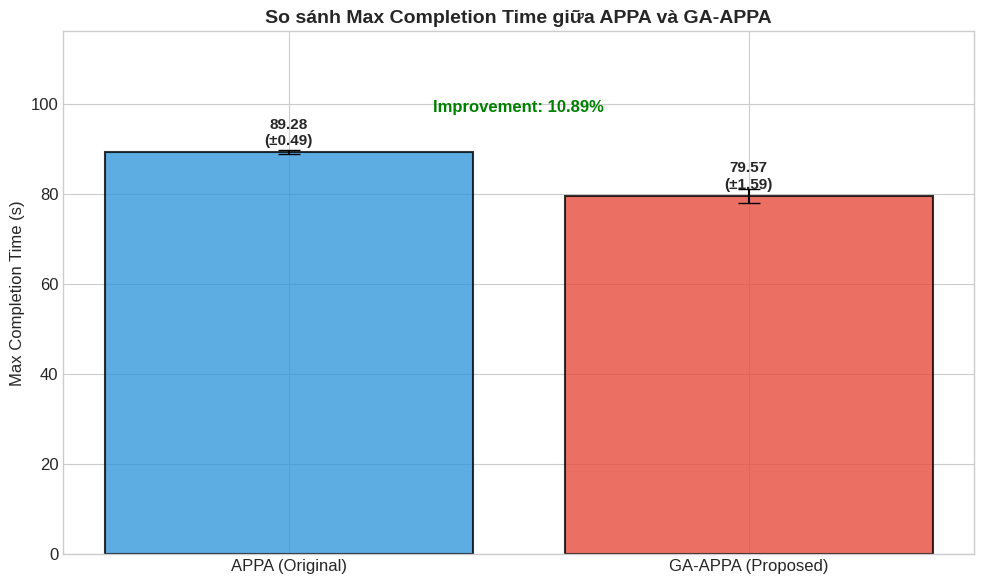

In [5]:
# Biểu đồ 1: Bar chart so sánh Max Completion Time
fig, ax = plt.subplots(figsize=(10, 6))

algorithms = ['APPA (Original)', 'GA-APPA (Proposed)']
means = [appa_stats['max_completion_time']['mean'], ga_appa_stats['max_completion_time']['mean']]
stds = [appa_stats['max_completion_time']['std'], ga_appa_stats['max_completion_time']['std']]
colors = ['#3498db', '#e74c3c']

bars = ax.bar(algorithms, means, yerr=stds, capsize=8, color=colors, alpha=0.8, edgecolor='black', linewidth=1.5)

# Add value labels on bars
for bar, mean, std in zip(bars, means, stds):
    height = bar.get_height()
    ax.annotate(f'{mean:.2f}\n(±{std:.2f})',
                xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3),
                textcoords="offset points",
                ha='center', va='bottom', fontsize=11, fontweight='bold')

ax.set_ylabel('Max Completion Time (s)', fontsize=12)
ax.set_title('So sánh Max Completion Time giữa APPA và GA-APPA', fontsize=14, fontweight='bold')
ax.set_ylim(0, max(means) * 1.3)

# Calculate improvement
improvement = (means[0] - means[1]) / means[0] * 100
ax.text(0.5, max(means) * 1.1, f'Improvement: {improvement:.2f}%', 
        ha='center', fontsize=12, color='green', fontweight='bold')

plt.tight_layout()
plt.savefig('./fig/max_completion_time_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

## 5. Box Plot so sánh Workload Balance

/tmp/ipykernel_464517/2256208717.py:12: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp1 = axes[0].boxplot([appa_max_times, ga_appa_max_times], labels=['APPA', 'GA-APPA'],
/tmp/ipykernel_464517/2256208717.py:22: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp2 = axes[1].boxplot([appa_workload_var, ga_appa_workload_var], labels=['APPA', 'GA-APPA'],


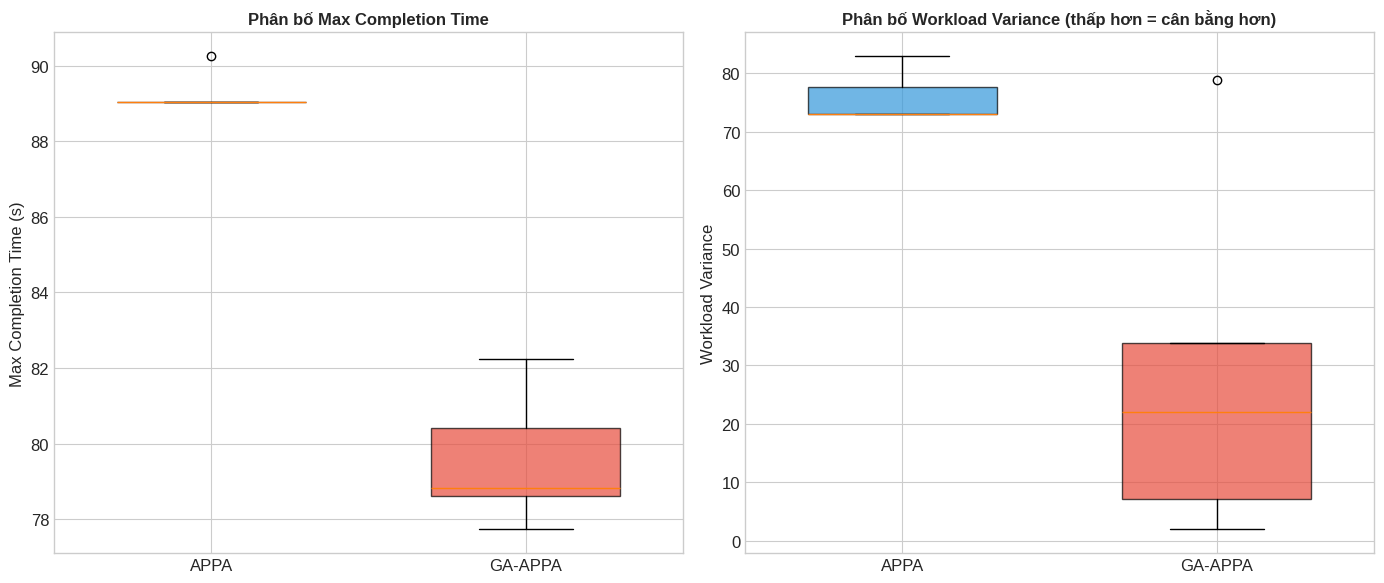

In [6]:
# Biểu đồ 2: Box plot so sánh completion times
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Get completion times from all runs
appa_max_times = [m['max_completion_time'] for m in appa_results]
ga_appa_max_times = [m['max_completion_time'] for m in ga_appa_results]

appa_workload_var = [m['workload_variance'] for m in appa_results]
ga_appa_workload_var = [m['workload_variance'] for m in ga_appa_results]

# Box plot for max completion time
bp1 = axes[0].boxplot([appa_max_times, ga_appa_max_times], labels=['APPA', 'GA-APPA'], 
                       patch_artist=True, widths=0.6)
colors = ['#3498db', '#e74c3c']
for patch, color in zip(bp1['boxes'], colors):
    patch.set_facecolor(color)
    patch.set_alpha(0.7)
axes[0].set_ylabel('Max Completion Time (s)', fontsize=12)
axes[0].set_title('Phân bố Max Completion Time', fontsize=12, fontweight='bold')

# Box plot for workload variance
bp2 = axes[1].boxplot([appa_workload_var, ga_appa_workload_var], labels=['APPA', 'GA-APPA'],
                       patch_artist=True, widths=0.6)
for patch, color in zip(bp2['boxes'], colors):
    patch.set_facecolor(color)
    patch.set_alpha(0.7)
axes[1].set_ylabel('Workload Variance', fontsize=12)
axes[1].set_title('Phân bố Workload Variance (thấp hơn = cân bằng hơn)', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.savefig('./fig/boxplot_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

## 6. Biểu đồ so sánh nhiều Metrics

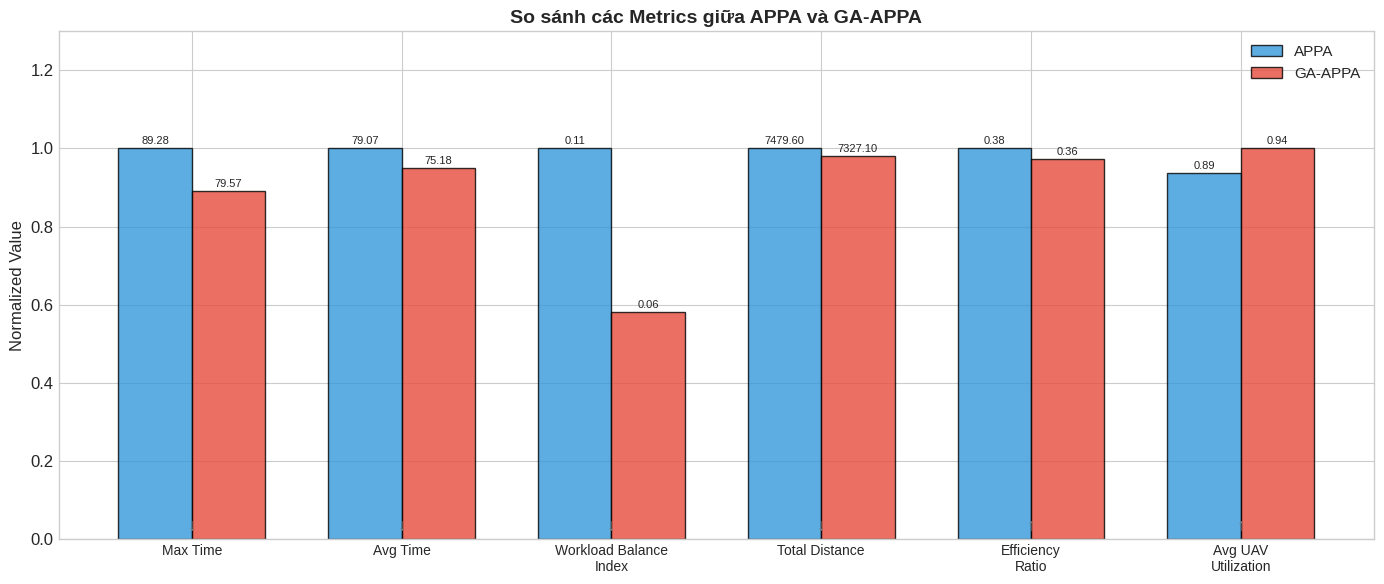

In [7]:
# Biểu đồ 3: Radar chart / grouped bar chart for multiple metrics
fig, ax = plt.subplots(figsize=(14, 6))

# Metrics to compare (normalized for visualization)
metrics_to_plot = [
    ('max_completion_time', 'Max Time', 'lower'),
    ('avg_completion_time', 'Avg Time', 'lower'),
    ('workload_balance_index', 'Workload Balance\nIndex', 'lower'),
    ('total_distance', 'Total Distance', 'lower'),
    ('efficiency_ratio', 'Efficiency\nRatio', 'higher'),
    ('avg_uav_utilization', 'Avg UAV\nUtilization', 'higher'),
]

x = np.arange(len(metrics_to_plot))
width = 0.35

appa_values = [appa_stats[m[0]]['mean'] for m in metrics_to_plot]
ga_appa_values = [ga_appa_stats[m[0]]['mean'] for m in metrics_to_plot]

# Normalize values for better visualization
max_vals = [max(a, g) for a, g in zip(appa_values, ga_appa_values)]
appa_norm = [a/m if m > 0 else 0 for a, m in zip(appa_values, max_vals)]
ga_appa_norm = [g/m if m > 0 else 0 for g, m in zip(ga_appa_values, max_vals)]

bars1 = ax.bar(x - width/2, appa_norm, width, label='APPA', color='#3498db', alpha=0.8, edgecolor='black')
bars2 = ax.bar(x + width/2, ga_appa_norm, width, label='GA-APPA', color='#e74c3c', alpha=0.8, edgecolor='black')

# Add annotations with actual values
for i, (bar1, bar2, v1, v2) in enumerate(zip(bars1, bars2, appa_values, ga_appa_values)):
    ax.annotate(f'{v1:.2f}', xy=(bar1.get_x() + bar1.get_width()/2, bar1.get_height()),
                xytext=(0, 3), textcoords="offset points", ha='center', fontsize=8)
    ax.annotate(f'{v2:.2f}', xy=(bar2.get_x() + bar2.get_width()/2, bar2.get_height()),
                xytext=(0, 3), textcoords="offset points", ha='center', fontsize=8)

ax.set_ylabel('Normalized Value', fontsize=12)
ax.set_title('So sánh các Metrics giữa APPA và GA-APPA', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels([m[1] for m in metrics_to_plot], fontsize=10)
ax.legend(loc='upper right', fontsize=11)
ax.set_ylim(0, 1.3)

# Add "lower is better" or "higher is better" annotations
for i, (_, _, direction) in enumerate(metrics_to_plot):
    symbol = '↓' if direction == 'lower' else '↑'
    ax.annotate(symbol, xy=(i, 0.02), ha='center', fontsize=12, color='gray')

plt.tight_layout()
plt.savefig('./fig/metrics_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

## 7. GA Convergence Curve

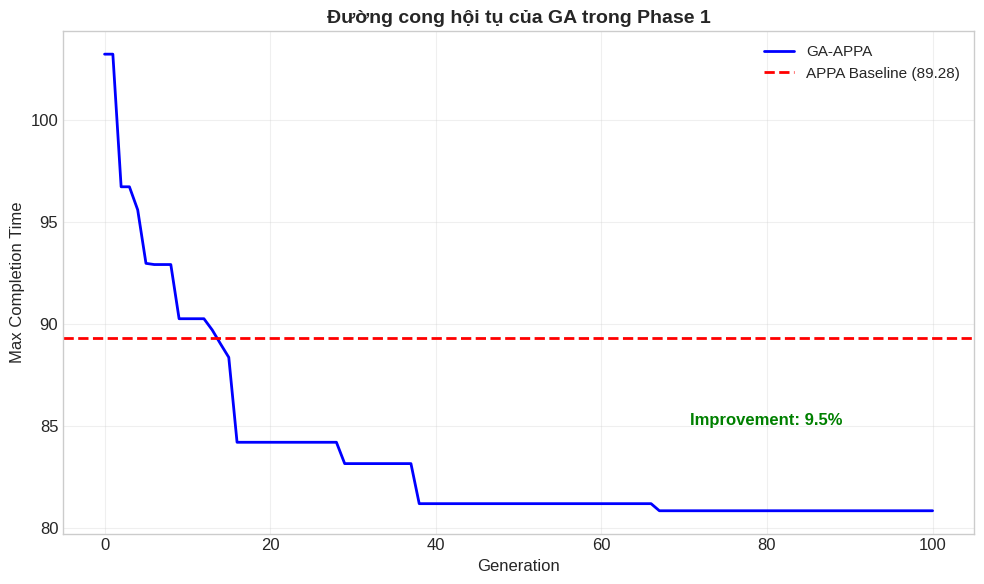

In [8]:
# Biểu đồ 4: GA Convergence curve
fig, ax = plt.subplots(figsize=(10, 6))

# Get fitness history from last run
if 'ga_fitness_history' in ga_appa_results[-1] and ga_appa_results[-1]['ga_fitness_history']:
    fitness_history = ga_appa_results[-1]['ga_fitness_history']
    # Convert fitness to completion time (fitness = 1/(time + eps))
    completion_time_history = [1.0 / (f + 1e-6) if f > 0 else 0 for f in fitness_history]
    
    generations = range(len(completion_time_history))
    ax.plot(generations, completion_time_history, 'b-', linewidth=2, label='GA-APPA')
    
    # Add APPA baseline
    appa_baseline = appa_stats['max_completion_time']['mean']
    ax.axhline(y=appa_baseline, color='r', linestyle='--', linewidth=2, label=f'APPA Baseline ({appa_baseline:.2f})')
    
    ax.set_xlabel('Generation', fontsize=12)
    ax.set_ylabel('Max Completion Time', fontsize=12)
    ax.set_title('Đường cong hội tụ của GA trong Phase 1', fontsize=14, fontweight='bold')
    ax.legend(loc='upper right', fontsize=11)
    ax.grid(True, alpha=0.3)
    
    # Highlight improvement
    final_time = completion_time_history[-1]
    improvement = (appa_baseline - final_time) / appa_baseline * 100
    ax.text(len(generations)*0.7, (appa_baseline + final_time)/2, 
            f'Improvement: {improvement:.1f}%', fontsize=12, color='green', fontweight='bold')
    
    plt.tight_layout()
    plt.savefig('./fig/ga_convergence.png', dpi=300, bbox_inches='tight')
    plt.show()
else:
    print("No GA fitness history available")

## 8. Execution Time Comparison

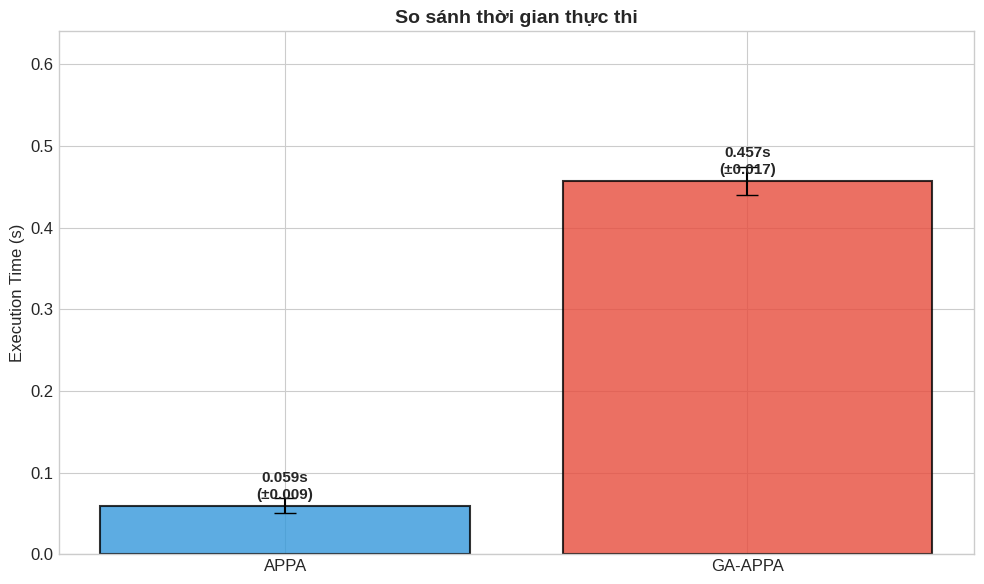

In [9]:
# Biểu đồ 5: Execution time comparison
fig, ax = plt.subplots(figsize=(10, 6))

algorithms = ['APPA', 'GA-APPA']
exec_times = [appa_stats['execution_time']['mean'], ga_appa_stats['execution_time']['mean']]
exec_stds = [appa_stats['execution_time']['std'], ga_appa_stats['execution_time']['std']]
colors = ['#3498db', '#e74c3c']

bars = ax.bar(algorithms, exec_times, yerr=exec_stds, capsize=8, color=colors, alpha=0.8, edgecolor='black', linewidth=1.5)

# Add value labels
for bar, t, std in zip(bars, exec_times, exec_stds):
    height = bar.get_height()
    ax.annotate(f'{t:.3f}s\n(±{std:.3f})',
                xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3),
                textcoords="offset points",
                ha='center', va='bottom', fontsize=11, fontweight='bold')

ax.set_ylabel('Execution Time (s)', fontsize=12)
ax.set_title('So sánh thời gian thực thi', fontsize=14, fontweight='bold')
ax.set_ylim(0, max(exec_times) * 1.4)

plt.tight_layout()
plt.savefig('./fig/execution_time_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

## 9. Deviation Ratio Analysis

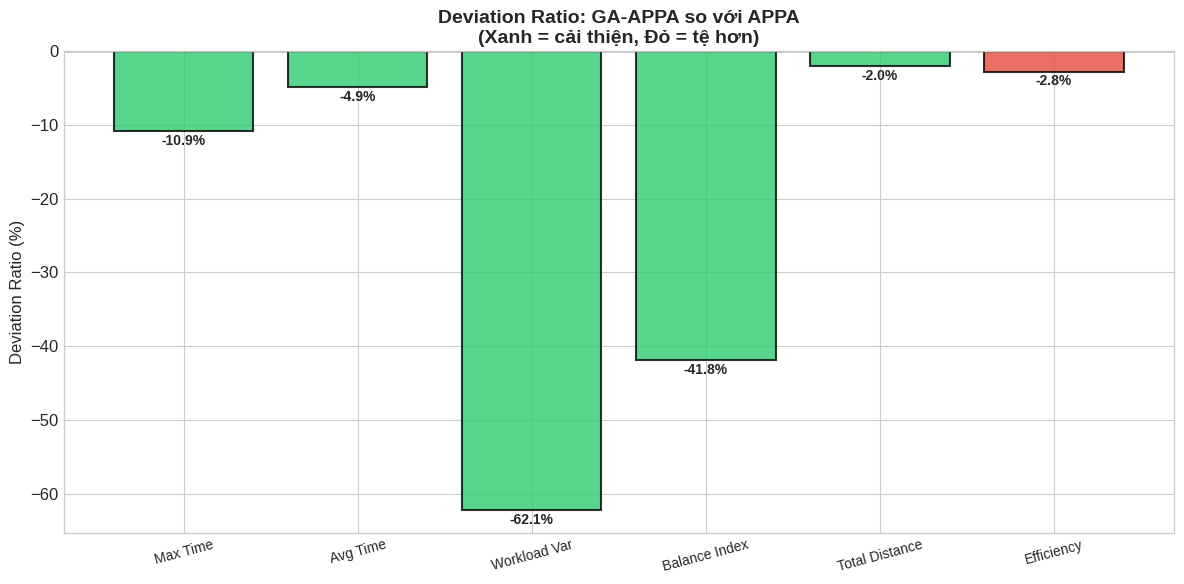

In [10]:
# Biểu đồ 6: Deviation ratio (improvement percentage)
fig, ax = plt.subplots(figsize=(12, 6))

# Calculate deviation ratios for each metric
deviation_metrics = [
    ('max_completion_time', 'Max Time', 'lower'),
    ('avg_completion_time', 'Avg Time', 'lower'),
    ('workload_variance', 'Workload Var', 'lower'),
    ('workload_balance_index', 'Balance Index', 'lower'),
    ('total_distance', 'Total Distance', 'lower'),
    ('efficiency_ratio', 'Efficiency', 'higher'),
]

deviations = []
colors_dev = []
for metric, label, direction in deviation_metrics:
    appa_val = appa_stats[metric]['mean']
    ga_val = ga_appa_stats[metric]['mean']
    
    if direction == 'lower':
        # Lower is better, so negative deviation means improvement
        deviation = ((ga_val - appa_val) / appa_val) * 100 if appa_val != 0 else 0
        is_better = deviation < 0
    else:
        # Higher is better, so positive deviation means improvement
        deviation = ((ga_val - appa_val) / appa_val) * 100 if appa_val != 0 else 0
        is_better = deviation > 0
    
    deviations.append(deviation)
    colors_dev.append('#2ecc71' if is_better else '#e74c3c')

x = range(len(deviation_metrics))
bars = ax.bar(x, deviations, color=colors_dev, alpha=0.8, edgecolor='black', linewidth=1.5)

# Add value labels
for bar, dev in zip(bars, deviations):
    height = bar.get_height()
    offset = 0.5 if height >= 0 else -2
    ax.annotate(f'{dev:.1f}%',
                xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, offset),
                textcoords="offset points",
                ha='center', va='bottom' if height >= 0 else 'top', fontsize=10, fontweight='bold')

ax.axhline(y=0, color='black', linestyle='-', linewidth=1)
ax.set_ylabel('Deviation Ratio (%)', fontsize=12)
ax.set_title('Deviation Ratio: GA-APPA so với APPA\n(Xanh = cải thiện, Đỏ = tệ hơn)', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels([m[1] for m in deviation_metrics], fontsize=10, rotation=15)

plt.tight_layout()
plt.savefig('./fig/deviation_ratio.png', dpi=300, bbox_inches='tight')
plt.show()

## 10. So sánh với các cấu hình khác nhau

In [11]:
# Thử nghiệm với số lượng regions khác nhau
def run_scalability_test(num_uavs=4, regions_range=[10, 20, 30, 40, 50]):
    """
    Test scalability với số lượng regions khác nhau
    """
    results = {'regions': [], 'appa_time': [], 'ga_appa_time': [], 'appa_max': [], 'ga_appa_max': []}
    
    for num_regions in regions_range:
        print(f"\nTesting with {num_regions} regions...")
        
        uavs, regions, v_matrix = generate_test_data(num_uavs=num_uavs, num_regions=num_regions)
        
        # Run APPA
        appa = APPAAlgorithm(uavs, regions, v_matrix.tolist())
        start = time.time()
        appa_result = appa.solve()
        appa_time = time.time() - start
        
        # Run GA-APPA
        ga_appa = GAPPAAlgorithm(uavs, regions, v_matrix.tolist(),
                                  ga_population_size=50, ga_max_generations=100)
        start = time.time()
        ga_appa_result = ga_appa.solve()
        ga_appa_time = time.time() - start
        
        results['regions'].append(num_regions)
        results['appa_time'].append(appa_time)
        results['ga_appa_time'].append(ga_appa_time)
        results['appa_max'].append(appa_result['max_completion_time'])
        results['ga_appa_max'].append(ga_appa_result['max_completion_time'])
        
        print(f"  APPA: {appa_result['max_completion_time']:.2f} ({appa_time:.3f}s)")
        print(f"  GA-APPA: {ga_appa_result['max_completion_time']:.2f} ({ga_appa_time:.3f}s)")
    
    return results

scalability_results = run_scalability_test(num_uavs=4, regions_range=[10, 20, 30, 40, 50])


Testing with 10 regions...
  APPA: 92.21 (0.014s)
  GA-APPA: 61.75 (0.261s)

Testing with 20 regions...
  APPA: 78.04 (0.049s)
  GA-APPA: 69.90 (0.360s)

Testing with 30 regions...
  APPA: 90.26 (0.056s)
  GA-APPA: 78.61 (0.512s)

Testing with 40 regions...
  APPA: 91.61 (0.092s)
  GA-APPA: 86.20 (0.706s)

Testing with 50 regions...
  APPA: 107.18 (0.165s)
  GA-APPA: 104.54 (0.979s)


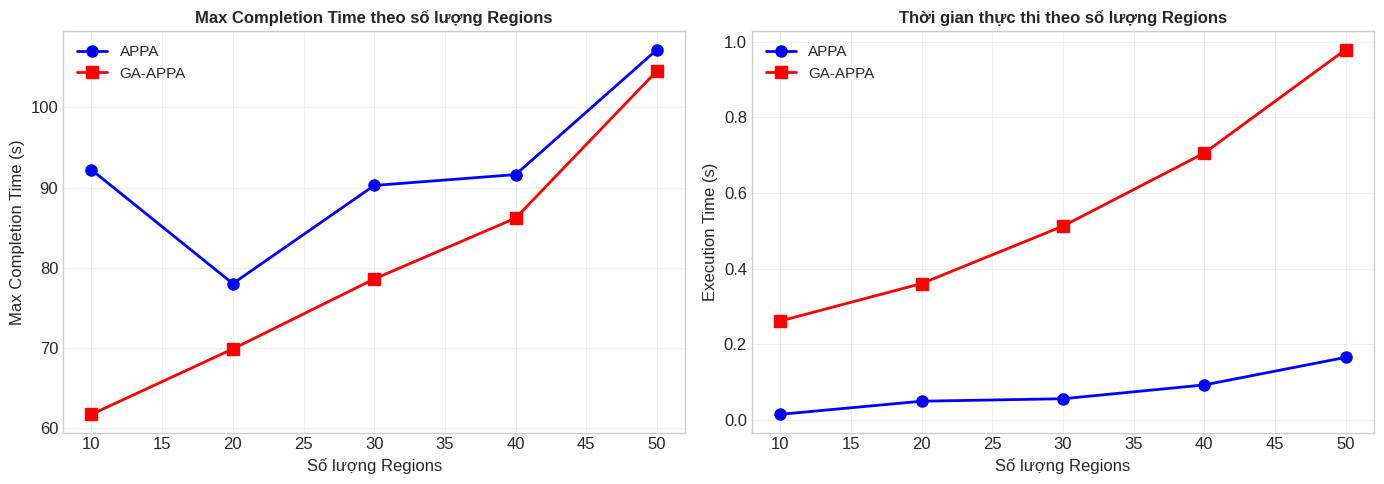

In [12]:
# Biểu đồ 7: Scalability analysis
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Max completion time vs number of regions
axes[0].plot(scalability_results['regions'], scalability_results['appa_max'], 
             'b-o', linewidth=2, markersize=8, label='APPA')
axes[0].plot(scalability_results['regions'], scalability_results['ga_appa_max'], 
             'r-s', linewidth=2, markersize=8, label='GA-APPA')
axes[0].set_xlabel('Số lượng Regions', fontsize=12)
axes[0].set_ylabel('Max Completion Time (s)', fontsize=12)
axes[0].set_title('Max Completion Time theo số lượng Regions', fontsize=12, fontweight='bold')
axes[0].legend(loc='upper left', fontsize=11)
axes[0].grid(True, alpha=0.3)

# Execution time vs number of regions
axes[1].plot(scalability_results['regions'], scalability_results['appa_time'], 
             'b-o', linewidth=2, markersize=8, label='APPA')
axes[1].plot(scalability_results['regions'], scalability_results['ga_appa_time'], 
             'r-s', linewidth=2, markersize=8, label='GA-APPA')
axes[1].set_xlabel('Số lượng Regions', fontsize=12)
axes[1].set_ylabel('Execution Time (s)', fontsize=12)
axes[1].set_title('Thời gian thực thi theo số lượng Regions', fontsize=12, fontweight='bold')
axes[1].legend(loc='upper left', fontsize=11)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('./fig/scalability_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

## 11. Tổng kết kết quả

In [13]:
# Summary table
print("\n" + "="*80)
print("TỔNG KẾT KẾT QUẢ")
print("="*80)

improvement_max = (appa_stats['max_completion_time']['mean'] - ga_appa_stats['max_completion_time']['mean']) / appa_stats['max_completion_time']['mean'] * 100
improvement_workload = (appa_stats['workload_variance']['mean'] - ga_appa_stats['workload_variance']['mean']) / appa_stats['workload_variance']['mean'] * 100 if appa_stats['workload_variance']['mean'] > 0 else 0
improvement_efficiency = (ga_appa_stats['efficiency_ratio']['mean'] - appa_stats['efficiency_ratio']['mean']) / appa_stats['efficiency_ratio']['mean'] * 100 if appa_stats['efficiency_ratio']['mean'] > 0 else 0

print(f"\n1. Max Completion Time:")
print(f"   - APPA: {appa_stats['max_completion_time']['mean']:.2f} ± {appa_stats['max_completion_time']['std']:.2f}")
print(f"   - GA-APPA: {ga_appa_stats['max_completion_time']['mean']:.2f} ± {ga_appa_stats['max_completion_time']['std']:.2f}")
print(f"   - Improvement: {improvement_max:.2f}%")

print(f"\n2. Workload Balance (variance):")
print(f"   - APPA: {appa_stats['workload_variance']['mean']:.2f}")
print(f"   - GA-APPA: {ga_appa_stats['workload_variance']['mean']:.2f}")
print(f"   - Improvement: {improvement_workload:.2f}%")

print(f"\n3. Efficiency Ratio:")
print(f"   - APPA: {appa_stats['efficiency_ratio']['mean']:.4f}")
print(f"   - GA-APPA: {ga_appa_stats['efficiency_ratio']['mean']:.4f}")
print(f"   - Change: {improvement_efficiency:.2f}%")

print(f"\n4. Execution Time:")
print(f"   - APPA: {appa_stats['execution_time']['mean']:.3f}s")
print(f"   - GA-APPA: {ga_appa_stats['execution_time']['mean']:.3f}s")

print("\n" + "="*80)
print(f"\nKết luận: GA-APPA cải thiện {improvement_max:.2f}% về Max Completion Time so với APPA gốc.")
print("="*80)


TỔNG KẾT KẾT QUẢ

1. Max Completion Time:
   - APPA: 89.28 ± 0.49
   - GA-APPA: 79.57 ± 1.59
   - Improvement: 10.89%

2. Workload Balance (variance):
   - APPA: 75.91
   - GA-APPA: 28.74
   - Improvement: 62.14%

3. Efficiency Ratio:
   - APPA: 0.3755
   - GA-APPA: 0.3650
   - Change: -2.80%

4. Execution Time:
   - APPA: 0.059s
   - GA-APPA: 0.457s


Kết luận: GA-APPA cải thiện 10.89% về Max Completion Time so với APPA gốc.


In [14]:
# List all saved figures
import os

print("\nCác biểu đồ đã được lưu:")
for f in os.listdir('./fig'):
    if f.endswith('.png'):
        print(f"  - ./fig/{f}")


Các biểu đồ đã được lưu:
  - ./fig/deviation_ratio.png
  - ./fig/ga_convergence.png
  - ./fig/boxplot_comparison.png
  - ./fig/metrics_comparison.png
  - ./fig/scalability_analysis.png
  - ./fig/max_completion_time_comparison.png
  - ./fig/execution_time_comparison.png
